# 01 — Data Loading, Cleaning & Preprocessing
**The Safe Lending Project**

This notebook:
1. Loads all 6 CSV tables from the `data/` folder
2. Inspects shapes, dtypes, and missing values
3. Merges tables into a unified master dataset (using row index since `id` is all NaN)
4. Handles missing values (drop high-null columns, impute others)
5. Creates binary target variable `is_default`
6. Filters to terminal loan statuses (Fully Paid + Charged Off)
7. Saves the cleaned dataset for EDA and modeling

In [10]:
# ── Section 1: Import Libraries ──
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')

DATA_DIR = os.path.join('..', 'data')
print("✅ Libraries loaded")

✅ Libraries loaded


## Section 2: Load All CSV Tables

In [2]:
# ── Section 2: Load all CSVs ──
loan_core = pd.read_csv(os.path.join(DATA_DIR, 'loan_core.csv'))
borrower_profile = pd.read_csv(os.path.join(DATA_DIR, 'borrower_profile.csv'))
credit_history = pd.read_csv(os.path.join(DATA_DIR, 'credit_history.csv'), low_memory=False)
account_balances = pd.read_csv(os.path.join(DATA_DIR, 'account_balances.csv'))
account_activity = pd.read_csv(os.path.join(DATA_DIR, 'account_activity.csv'))
extra_unassigned = pd.read_csv(os.path.join(DATA_DIR, 'extra_unassigned.csv'), low_memory=False)

tables = {
    'loan_core': loan_core,
    'borrower_profile': borrower_profile,
    'credit_history': credit_history,
    'account_balances': account_balances,
    'account_activity': account_activity,
    'extra_unassigned': extra_unassigned
}

for name, df in tables.items():
    print(f"{name:25s} → Shape: {str(df.shape):20s} | Columns: {df.shape[1]}")

print(f"\n✅ All tables loaded")

loan_core                 → Shape: (2260668, 6)         | Columns: 6
borrower_profile          → Shape: (2260668, 7)         | Columns: 7
credit_history            → Shape: (2260668, 8)         | Columns: 8
account_balances          → Shape: (2260668, 11)        | Columns: 11
account_activity          → Shape: (2260668, 21)        | Columns: 21
extra_unassigned          → Shape: (2260668, 94)        | Columns: 94

✅ All tables loaded


## Section 3: Inspect Tables — Shapes, Dtypes, Nulls

In [3]:
# ── Section 3: Quick inspection of each table ──
for name, df in tables.items():
    print(f"\n{'='*60}")
    print(f"  {name}  —  {df.shape[0]:,} rows × {df.shape[1]} cols")
    print(f"{'='*60}")
    print(df.dtypes.to_string())
    null_pct = (df.isnull().sum() / len(df) * 100).round(1)
    print(f"\nNull %:\n{null_pct.to_string()}")
    print(f"\nHead (2 rows):\n{df.head(2).to_string()}")


  loan_core  —  2,260,668 rows × 6 cols
id                     float64
term                       str
installment            float64
grade                      str
loan_status                str
disbursement_method        str

Null %:
id                    100.00
term                    0.00
installment             0.00
grade                   0.00
loan_status             0.00
disbursement_method     0.00

Head (2 rows):
   id        term  installment grade loan_status disbursement_method
0 NaN   36 months        84.92     C     Current                Cash
1 NaN   60 months       777.23     D     Current                Cash

  borrower_profile  —  2,260,668 rows × 7 cols
id                  float64
annual_inc_joint    float64
emp_title               str
application_type        str
purpose                 str
title                   str
zip_code                str

Null %:
id                 100.00
annual_inc_joint    94.70
emp_title            7.40
application_type     0.00
purpose   

## Section 4: Merge All Tables into a Master DataFrame
Since the `id` column is **ALL NaN** across every table, we use the **row index** (positional) as the implicit join key. All tables have the same number of rows (2,260,668) in 1:1 correspondence.

In [4]:
# ── Section 4: Merge using row index ──
# Drop the all-NaN 'id' column from every table before merging
dfs = []
for name, df in tables.items():
    temp = df.drop(columns=['id'], errors='ignore').copy()
    # Add prefix to avoid column name collisions (except extra_unassigned which has unique cols)
    dfs.append(temp)

# Concatenate column-wise (axis=1) since rows are aligned 1:1
master = pd.concat(dfs, axis=1)

# Check for duplicate column names
dup_cols = master.columns[master.columns.duplicated()].tolist()
if dup_cols:
    print(f"⚠️  Duplicate columns found: {dup_cols}")
    # Keep first occurrence only
    master = master.loc[:, ~master.columns.duplicated(keep='first')]

print(f"✅ Master DataFrame: {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"Memory: {master.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Free individual tables
del loan_core, borrower_profile, credit_history, account_balances, account_activity, extra_unassigned, dfs, tables
gc.collect()

✅ Master DataFrame: 2,260,668 rows × 142 columns
Memory: 6.09 GB


0

## Section 5: Missing Value Analysis
Identify columns with very high null % (>90%) — these will be dropped. The rest will be kept as-is or imputed only where truly needed.

Columns with >0% nulls:

member_id                                    100.00
orig_projected_additional_accrued_interest    99.63
hardship_length                               99.53
hardship_dpd                                  99.53
hardship_status                               99.53
hardship_start_date                           99.53
hardship_reason                               99.53
deferral_term                                 99.53
payment_plan_start_date                       99.53
hardship_type                                 99.53
hardship_loan_status                          99.53
hardship_payoff_balance_amount                99.53
hardship_last_payment_amount                  99.53
hardship_end_date                             99.53
hardship_amount                               99.53
settlement_amount                             98.54
debt_settlement_flag_date                     98.54
settlement_date                               98.54
settlement_percentage                  

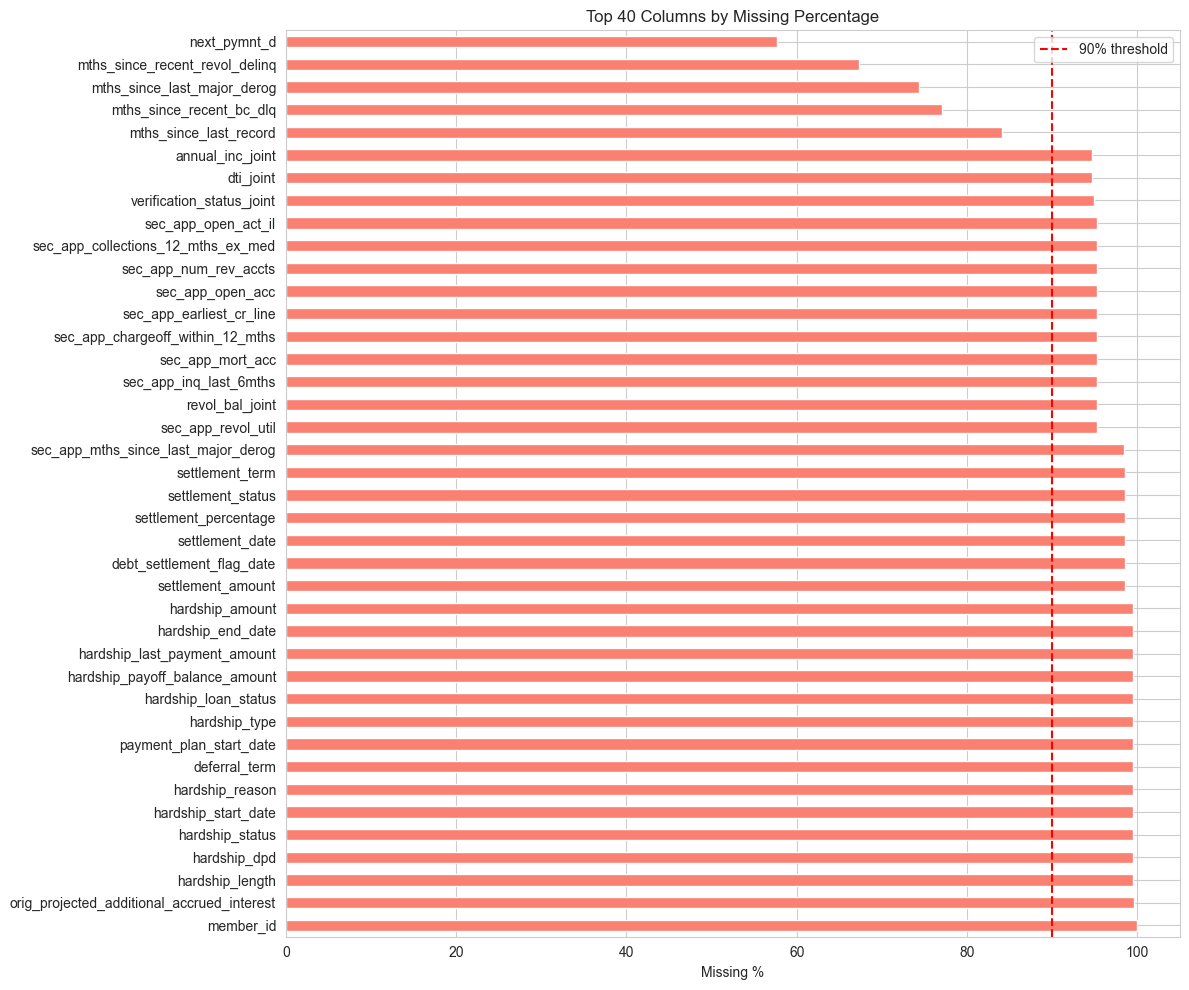


🗑️  Dropping 35 columns with >90% nulls:
   member_id: 100.0%
   orig_projected_additional_accrued_interest: 99.6%
   hardship_length: 99.5%
   hardship_dpd: 99.5%
   hardship_status: 99.5%
   hardship_start_date: 99.5%
   hardship_reason: 99.5%
   deferral_term: 99.5%
   payment_plan_start_date: 99.5%
   hardship_type: 99.5%
   hardship_loan_status: 99.5%
   hardship_payoff_balance_amount: 99.5%
   hardship_last_payment_amount: 99.5%
   hardship_end_date: 99.5%
   hardship_amount: 99.5%
   settlement_amount: 98.5%
   debt_settlement_flag_date: 98.5%
   settlement_date: 98.5%
   settlement_percentage: 98.5%
   settlement_status: 98.5%
   settlement_term: 98.5%
   sec_app_mths_since_last_major_derog: 98.4%
   sec_app_revol_util: 95.3%
   revol_bal_joint: 95.2%
   sec_app_inq_last_6mths: 95.2%
   sec_app_mort_acc: 95.2%
   sec_app_chargeoff_within_12_mths: 95.2%
   sec_app_earliest_cr_line: 95.2%
   sec_app_open_acc: 95.2%
   sec_app_num_rev_accts: 95.2%
   sec_app_collections_12_mths_e

In [5]:
# ── Section 5: Missing value analysis ──
null_pct = (master.isnull().sum() / len(master) * 100).sort_values(ascending=False)

# Show all columns with nulls
print("Columns with >0% nulls:\n")
print(null_pct[null_pct > 0].to_string())

# Visualize top 40 null columns
fig, ax = plt.subplots(figsize=(12, 10))
null_pct[null_pct > 0].head(40).plot.barh(ax=ax, color='salmon')
ax.set_xlabel('Missing %')
ax.set_title('Top 40 Columns by Missing Percentage')
ax.axvline(x=90, color='red', linestyle='--', label='90% threshold')
ax.legend()
plt.tight_layout()
plt.savefig('../charts/missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

# Columns to DROP (>90% null)
cols_to_drop = null_pct[null_pct > 90].index.tolist()
print(f"\n🗑️  Dropping {len(cols_to_drop)} columns with >90% nulls:")
for c in cols_to_drop:
    print(f"   {c}: {null_pct[c]:.1f}%")

## Section 6: Drop High-Null Columns & Create Target Variable
- Drop columns with >90% nulls (mostly sec_app_*, hardship_*, settlement_*, member_id)
- Create binary target: `is_default` → 1 if Charged Off/Default, 0 if Fully Paid
- Filter to only terminal statuses for modeling

In [6]:
# ── Section 6: Drop high-null columns, create target, filter ──

# 6a. Drop columns >90% null
master.drop(columns=cols_to_drop, inplace=True)
print(f"After dropping high-null columns: {master.shape[1]} columns remain")

# 6b. Check loan_status distribution
print("\nLoan Status distribution:")
print(master['loan_status'].value_counts())

# 6c. Create binary target variable
default_statuses = ['Charged Off', 'Default',
                    'Late (31-120 days)', 'Late (16-30 days)',
                    'Does not meet the credit policy. Status:Charged Off']
paid_statuses = ['Fully Paid',
                 'Does not meet the credit policy. Status:Fully Paid']

# Keep ALL rows for EDA (save full version)
master['is_default'] = master['loan_status'].apply(
    lambda x: 1 if x in default_statuses else (0 if x in paid_statuses else np.nan)
)

print(f"\nis_default value counts (NaN = non-terminal status like Current/Grace Period):")
print(master['is_default'].value_counts(dropna=False))

# 6d. Save full master for EDA (includes Current loans etc.)
print(f"\n✅ Full master shape: {master.shape}")
print(f"Memory: {master.memory_usage(deep=True).sum() / 1e9:.2f} GB")

After dropping high-null columns: 107 columns remain

Loan Status distribution:
loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

is_default value counts (NaN = non-terminal status like Current/Grace Period):
is_default
0.00    1043940
NaN      928647
1.00     288081
Name: count, dtype: int64

✅ Full master shape: (2260668, 108)
Memory: 4.81 GB


## Section 7: Minimal Cleaning — Only What's Required
- Convert `issue_d` and date columns to datetime
- Convert `emp_length` to numeric years
- Convert `term` to numeric months
- Convert `revol_util` if it's a string with %
- Downcast floats to save memory

In [7]:
# ── Section 7: Minimal cleaning ──

# 7a. Convert term to numeric (e.g. " 36 months" → 36)
if master['term'].dtype == object or str(master['term'].dtype) == 'str':
    master['term'] = master['term'].str.extract(r'(\d+)').astype(float)
    print(f"✅ term → numeric. Unique values: {sorted(master['term'].dropna().unique())}")

# 7b. Convert emp_length to numeric years
if 'emp_length' in master.columns:
    emp_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
        '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
        '8 years': 8, '9 years': 9, '10+ years': 10
    }
    master['emp_length_yrs'] = master['emp_length'].map(emp_map)
    print(f"✅ emp_length → emp_length_yrs. Nulls: {master['emp_length_yrs'].isnull().sum():,}")

# 7c. Convert issue_d to datetime
if 'issue_d' in master.columns:
    master['issue_d'] = pd.to_datetime(master['issue_d'], format='%b-%Y', errors='coerce')
    master['issue_year'] = master['issue_d'].dt.year
    master['issue_month'] = master['issue_d'].dt.month
    print(f"✅ issue_d → datetime. Year range: {master['issue_year'].min():.0f} – {master['issue_year'].max():.0f}")

# 7d. Convert earliest_cr_line to datetime
if 'earliest_cr_line' in master.columns:
    master['earliest_cr_line'] = pd.to_datetime(master['earliest_cr_line'], format='%b-%Y', errors='coerce')
    master['credit_history_years'] = (master['issue_d'] - master['earliest_cr_line']).dt.days / 365.25
    print(f"✅ credit_history_years computed")

# 7e. Handle revol_util if string
if 'revol_util' in master.columns and master['revol_util'].dtype == object:
    master['revol_util'] = master['revol_util'].str.rstrip('%').astype(float)
    print(f"✅ revol_util → numeric")

# 7f. Convert int_rate if string
if 'int_rate' in master.columns and master['int_rate'].dtype == object:
    master['int_rate'] = master['int_rate'].str.rstrip('%').astype(float)
    print(f"✅ int_rate → numeric")

print(f"\n✅ Minimal cleaning done. Shape: {master.shape}")

✅ term → numeric. Unique values: [np.float64(36.0), np.float64(60.0)]
✅ emp_length → emp_length_yrs. Nulls: 146,907
✅ issue_d → datetime. Year range: 2007 – 2018
✅ credit_history_years computed

✅ Minimal cleaning done. Shape: (2260668, 112)


## Section 8: Save Cleaned Datasets
- **Full master** (all loan statuses) → for EDA
- **Modeling subset** (only Fully Paid + Charged Off) → for ML

In [8]:
# ── Section 8: Save cleaned datasets ──

# 8a. Save full master for EDA
master.to_csv(os.path.join(DATA_DIR, 'master_full.csv'), index=False)
print(f"✅ Saved master_full.csv → {master.shape[0]:,} rows × {master.shape[1]} cols")

# 8b. Create modeling subset (terminal statuses only)
model_df = master[master['is_default'].notna()].copy()
model_df['is_default'] = model_df['is_default'].astype(int)
model_df.to_csv(os.path.join(DATA_DIR, 'master_modeling.csv'), index=False)
print(f"✅ Saved master_modeling.csv → {model_df.shape[0]:,} rows × {model_df.shape[1]} cols")

# 8c. Target distribution for modeling
print(f"\nTarget distribution (modeling set):")
print(model_df['is_default'].value_counts())
print(f"\nDefault rate: {model_df['is_default'].mean()*100:.2f}%")

del model_df
gc.collect()
print("\n🎉 Data cleaning complete! Ready for EDA and Modeling.")

✅ Saved master_full.csv → 2,260,668 rows × 112 cols
✅ Saved master_modeling.csv → 1,332,021 rows × 112 cols

Target distribution (modeling set):
is_default
0    1043940
1     288081
Name: count, dtype: int64

Default rate: 21.63%

🎉 Data cleaning complete! Ready for EDA and Modeling.
